# Spectral method for a  Hugget model with two incomes

In [1]:
%run 'backend.ipynb'
backend_test_function()

Backend import successful! - 2023-12-18 18:09:13.184208


In [2]:
from dmsuite.poly_diff import Chebyshev, Lagrange, DiffMatOnDomain

# Economic parameters

In [57]:
gamma = 1.2 # CRRA utility parameter
def u(x): return x**(1-gamma) / (1-gamma) # Utility function
def du(x): return x**(-gamma) # Marginal utility
def du_inv(x): return x**(-1/gamma) # Inverse marginal utility
rho = 0.05 # Discount rate

r = 0.035 # Interest rate

zlow, zhigh = 0.1, 0.2 # High, low income states
z = np.array([zlow, zhigh])

lambda1, lambda2 = 1.5, 1. # Low->high, high->low transition rates
G = np.array([[-lambda1, lambda1], [lambda2, -lambda2]]) # Generator / transition rate matrix

amin, amax = -0.02, 1. # Lower, upper asset constraint

## Numerical parameters

In [58]:
maxiter = 100
crit = 1e-10

# Hamilton-Jacobi-Bellman Equation

## Finite differences

In [59]:
I = 500
a_fd = np.linspace(amin, amax, I)
da_fd = (amax-amin)/(I-1)

aa_fd = np.tile(a_fd,(2,1))
zz_fd = np.tile(z,(I,1)).T

delta = 2000.

In [60]:
# Switching matrix
z_transition = sparse.kron(G,sparse.eye(I), format='csr') 

# Initialization
v_old = np.zeros((2,I))
g = np.zeros((2,I))
dv = np.zeros((2,I-1))
cf = np.zeros((2,I-1))
c0 = np.zeros((2,I))
ssf = np.zeros((2,I))
ssb = np.zeros((2,I))
is_backward = np.zeros((2,I))
is_forward = np.zeros((2,I))
diag_helper = np.zeros((2,I))        
A = z_transition.copy()
B = z_transition.copy()

# Initial guess
v0_fd = u(r*aa_fd + zz_fd)/rho

In [61]:
%%time

v_fd = v0_fd.copy()

for i in range(maxiter):
            
    dv = (v_fd[:,1:]-v_fd[:,:-1])/da_fd
    cf = du_inv(dv)
    c0 = r*aa_fd + zz_fd
    
    ssf[:,:-1] = c0[:,:-1]-cf
    ssb[:,1:] = c0[:,1:]-cf

    is_backward = ssf>0
    is_forward = ssb<0
    
    c0[:,:-1] += (cf-c0[:,:-1])*is_backward[:,:-1]
    c0[:,1:] += (cf-c0[:,1:])*is_forward[:,1:]
    
    A = z_transition.copy()
    diag_helper = (-ssf*is_backward/da_fd + ssb*is_forward/da_fd).flatten()
    A += sparse.spdiags(diag_helper,0,2*I,2*I)
    diag_helper = (-ssb*is_forward/da_fd).flatten()
    A += sparse.spdiags(diag_helper[1:],-1,2*I,2*I)
    diag_helper = (ssf*is_backward/da_fd).flatten()
    A += sparse.spdiags(np.hstack((0,diag_helper)),1,2*I,2*I)
    
    B = sparse.eye(2*I)*(1/delta + rho) - A
    b = u(c0).reshape(-1,1) + v_fd.reshape(-1,1)/delta
    A_fd, v_old, s_fd = A.copy(), v_fd.copy(), (r*aa_fd + zz_fd - c0)
    v_fd = spsolve(B,b).reshape(2,I)

    dist = np.max(np.abs(v_old-v_fd))
    if dist < crit:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

Finished! - Loops: 13  - Last distance: 4.4707348934025504e-11  - Last delta: 2000.0
CPU times: user 44.5 ms, sys: 4.14 ms, total: 48.6 ms
Wall time: 58.1 ms


In [62]:
zz_fd, aa_fd = zz_fd.flatten(), aa_fd.flatten()
v_fd, s_fd = v_fd.flatten(), s_fd.flatten()

## Spectral method

In [63]:
# Chebyshev nodes and differentiation matrices
N = 30
chebyshev = DiffMatOnDomain(xmin=amin, xmax=amax, dmat=Chebyshev(degree=N-1))
a_sp = chebyshev.nodes
Da = chebyshev.at_order(1)

# Tile and repeated arrays
aa_sp = np.tile(a_sp, 2)
zz_sp = np.repeat(z, N)

# Differentiation matrix w.r.t. a
D_a = np.kron(np.eye(2), Da)

# Switching matrix
GG = np.kron(G,np.eye(N))

# Initial guess
v0_sp = u(zz_sp+r*aa_sp)/rho

In [64]:
%%time

v_sp = v0_sp.copy()

for i in range(maxiter):
    
    delta = 0.01*np.exp(i)
    
    dv = D_a@v_sp
    c = du_inv(dv)
    s_sp = zz_sp + r*aa_sp - c
    
    A = s_sp.reshape(-1,1)*D_a + GG
    B = (1/delta + rho)*np.eye(2*N) - A
    b = u(c) + v_sp/delta
    
    B[0] = D_a[0]
    b[0] = du(zz_sp + r*aa_sp)[0]
    
    v_old = v_sp.copy()
    v_sp = np.linalg.solve(B,b)
    
    dist = np.max(np.abs(v_old-v_sp))
    
    if dist < crit:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

Finished! - Loops: 16  - Last distance: 1.531930138298776e-11  - Last delta: 32690.173724721106
CPU times: user 9.33 ms, sys: 4.15 ms, total: 13.5 ms
Wall time: 13 ms


In [65]:
v_sp, s_sp = v_sp.flatten(), s_sp.flatten()

## Output plots and boundary conditions

In [66]:
print("Boundary condition check (we want v'<=u'):")
print("u'(zlow+r*amin):", du(zlow+r*amin))
print("v'_low(amin):", (D_a@v_sp)[0])
print("u'(zhigh+r*amax):", du(zhigh+r*amax))
print("v'_high(amax):", (D_a@v_sp)[-1])

Boundary condition check (we want v'<=u'):
u'(zlow+r*amin): 15.983095772511849
v'_low(amin): 15.983095772535307
u'(zhigh+r*amax): 5.684844179713957
v'_high(amax): 5.4065195050498005


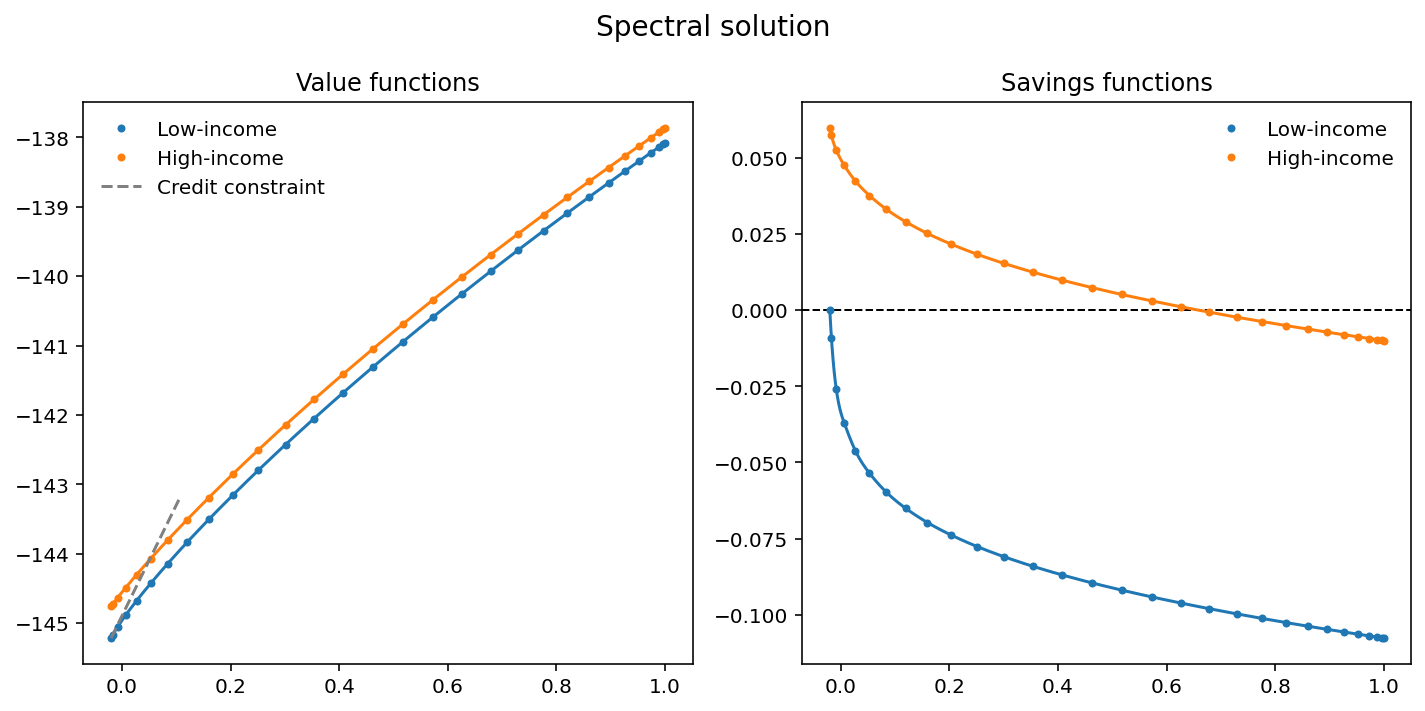

Saved to: two_state_value_function_savings_function.pdf


In [67]:
fd_bc_low = v_fd[0] + (a_fd-amin)*du(zlow+r*amin)
fd_sp_low = v_sp[0] + (a_fd-amin)*du(zlow+r*amin)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_sp, v_sp[:N], 'C0.', label='Low-income')
ax[0].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_fd), 'C0')
ax[0].plot(a_sp, v_sp[N:], 'C1.', label='High-income')
ax[0].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_fd), 'C1')
ax[0].plot(a_fd[:I//8], fd_sp_low[:I//8], c='grey', ls='--', label='Credit constraint')
ax[0].set_title('Value functions')
ax[0].legend(loc='upper left', frameon=False)

ax[1].plot(a_sp, s_sp[:N], 'C0.', label='Low-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_fd), 'C0')
ax[1].plot(a_sp, s_sp[N:], 'C1.', label='High-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_fd), 'C1')
ax[1].axhline(0, c='k', ls='--', lw=1, zorder=-1)
ax[1].set_title('Savings functions')
ax[1].legend(loc='upper right', frameon=False)

fig.suptitle('Spectral solution', size=14)
plt.tight_layout()
savefig(fig, 'two_state_value_function_savings_function')

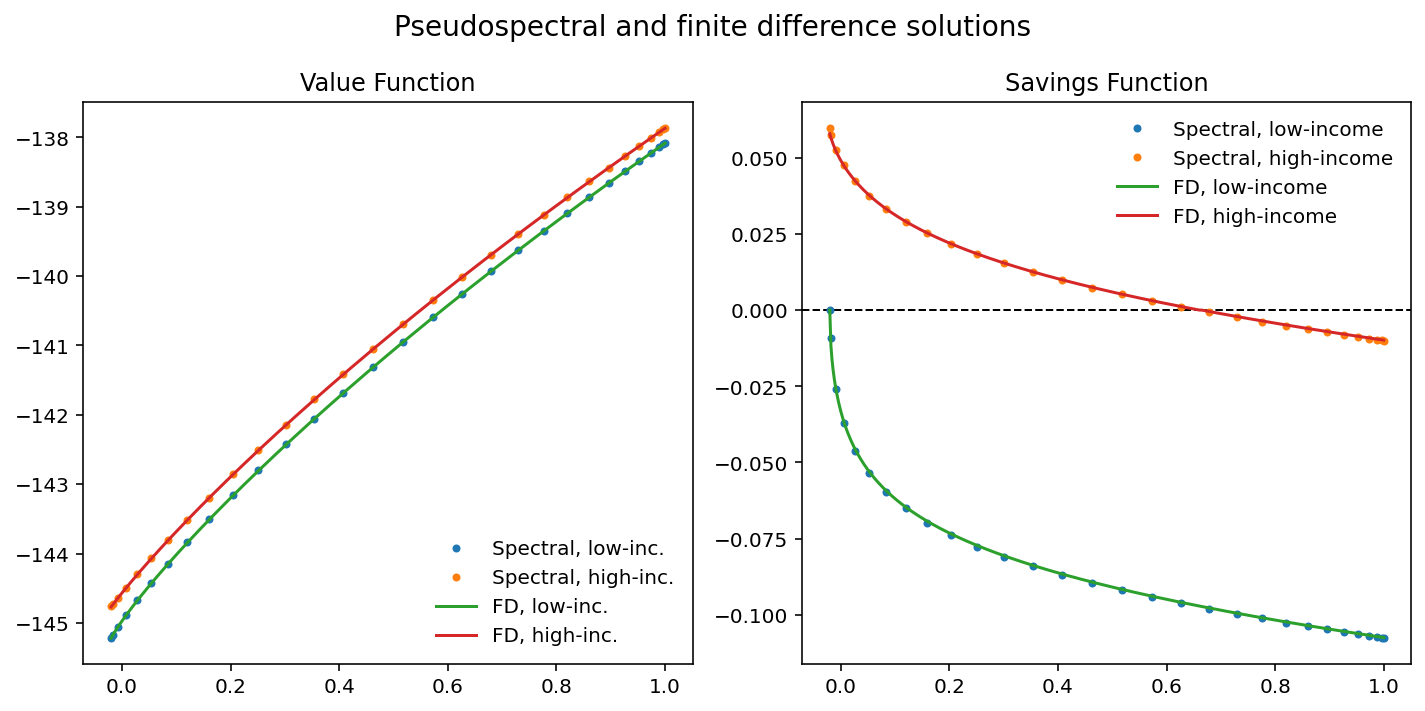

Saved to: two_state_value_functions_savings_fds_overlaid.pdf


In [68]:
a_hd = np.linspace(amin, amax, 10000)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_sp, v_sp[:N], 'C0.', label='Spectral, low-inc.')
ax[0].plot(a_sp, v_sp[N:], 'C1.', label='Spectral, high-inc.')
ax[0].plot(a_fd, v_fd[:I], 'C2', label='FD, low-inc.')
ax[0].plot(a_fd, v_fd[I:], 'C3', label='FD, high-inc.')
ax[0].set_title('Value Function')
ax[0].legend(loc='lower right', frameon=False)

ax[1].plot(a_sp, s_sp[:N], 'C0.', label='Spectral, low-income')
ax[1].plot(a_sp, s_sp[N:], 'C1.', label='Spectral, high-income')
ax[1].plot(a_fd, s_fd[:I], 'C2', label='FD, low-income')
ax[1].plot(a_fd, s_fd[I:], 'C3', label='FD, high-income')
ax[1].axhline(0, c='k', ls='--', lw=1, zorder=-1)
ax[1].set_title('Savings Function')
ax[1].legend(loc='upper right', frameon=False)

fig.suptitle('Pseudospectral and finite difference solutions', size=14)
plt.tight_layout()
savefig(fig, 'two_state_value_functions_savings_fds_overlaid')

## Error plots

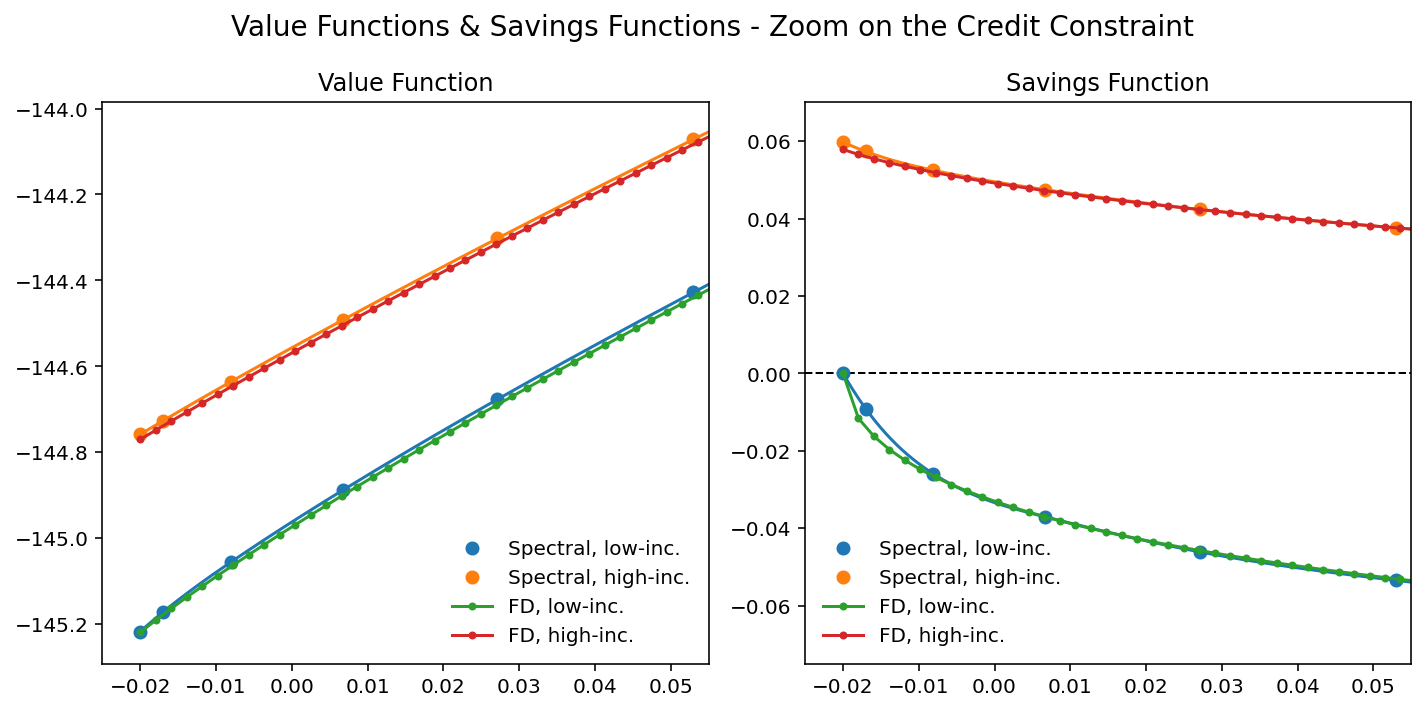

Saved to: two_state_value_functions_savings_fds_vs_spectral_zoombottom.pdf


In [69]:
a_hd = np.linspace(amin, amax, 10000)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()


ax[0].plot(a_sp, v_sp[:N], 'C0o', label='Spectral, low-inc.')
ax[0].plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_hd), 'C0')
ax[0].plot(a_sp, v_sp[N:], 'C1o', label='Spectral, high-inc.')
ax[0].plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_hd), 'C1')
ax[0].plot(a_fd, v_fd[:I], 'C2.-', label='FD, low-inc.')
ax[0].plot(a_fd, v_fd[I:], 'C3.-', label='FD, high-inc.')
ax[0].set_title('Value Function')
ax[0].legend(loc='lower right', frameon=False)

ax[0].set_xlim([amin-0.005,0.05])
ax[0].set_ylim([1.0005*v_fd[0], 0.9915*v_fd[0]])

ax[1].plot(a_sp, s_sp[:N], 'C0o', label='Spectral, low-inc.')
ax[1].plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_hd), 'C0')
ax[1].plot(a_sp, s_sp[N:], 'C1o', label='Spectral, high-inc.')
ax[1].plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_hd), 'C1')
ax[1].plot(a_fd, s_fd[:I], 'C2.-', label='FD, low-inc.')
ax[1].plot(a_fd, s_fd[I:], 'C3.-', label='FD, high-inc.')
ax[1].axhline(0, c='k', ls='--', lw=1, zorder=-1)
ax[1].set_title('Savings Function')
ax[1].legend(loc='lower left', frameon=False)

ax[1].set_xlim([amin-0.005,0.055])
ax[1].set_ylim([-0.075, 0.07])

fig.suptitle('Value Functions & Savings Functions - Zoom on the Credit Constraint', size=14)
plt.tight_layout()
savefig(fig, 'two_state_value_functions_savings_fds_vs_spectral_zoombottom')

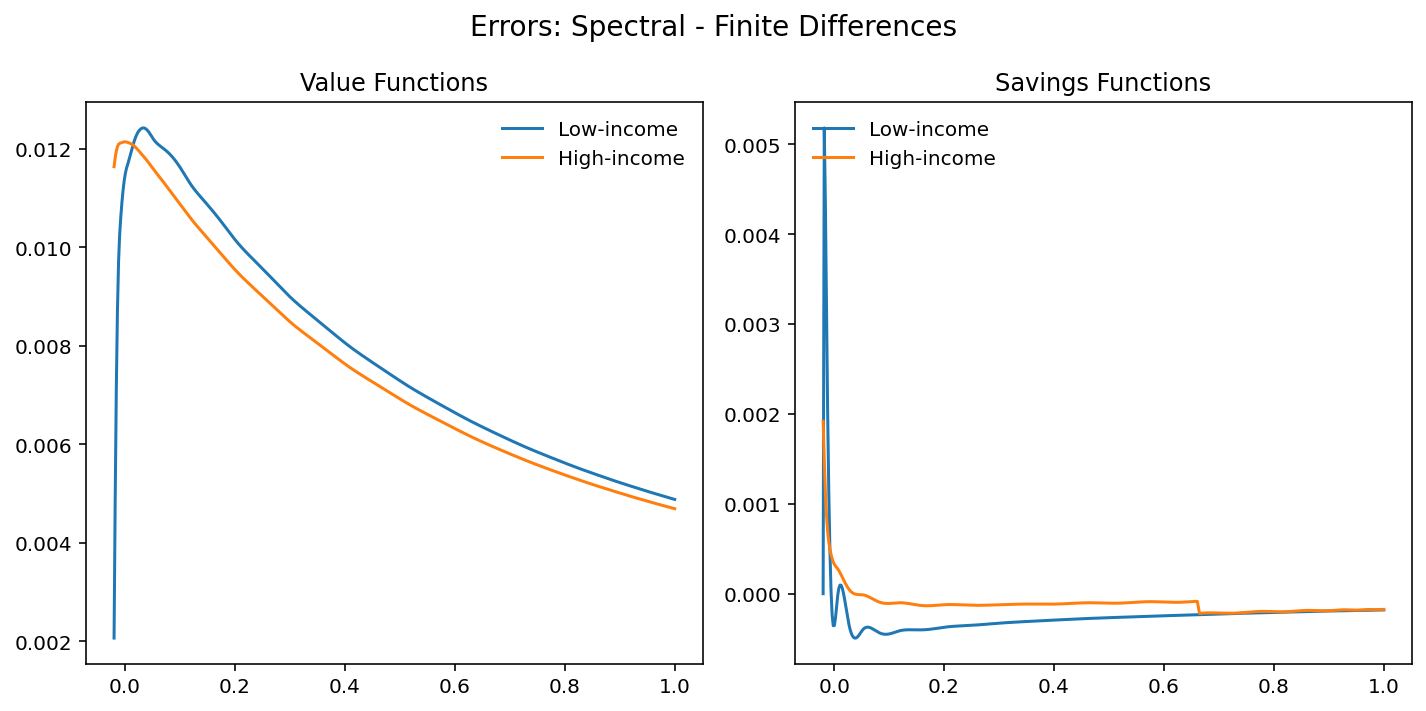

Saved to: two_state_errors_value_functions_and_savings_functions.pdf


In [70]:
fd_bc_low = v_fd[0] + (a_fd-amin)*du(zlow+r*amin)
fd_sp_low = v_sp[0] + (a_fd-amin)*du(zlow+r*amin)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[:N])(a_fd)-v_fd[:I], 'C0', label='Low-income')
ax[0].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, v_sp[N:])(a_fd)-v_fd[I:], 'C1', label='High-income')
ax[0].legend(loc='upper right', frameon=False)
ax[0].set_title('Value Functions')

ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_fd)-s_fd[:I], 'C0', label='Low-income')
ax[1].plot(a_fd, sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_fd)-s_fd[I:], 'C1', label='High-income')
ax[1].legend(loc='upper left', frameon=False)
ax[1].set_title('Savings Functions')

fig.suptitle('Errors: Spectral - Finite Differences', size=14)
plt.tight_layout()
savefig(fig, 'two_state_errors_value_functions_and_savings_functions')

In [71]:
# CCC: come up with CONVINCING explanation

## Matrix plots

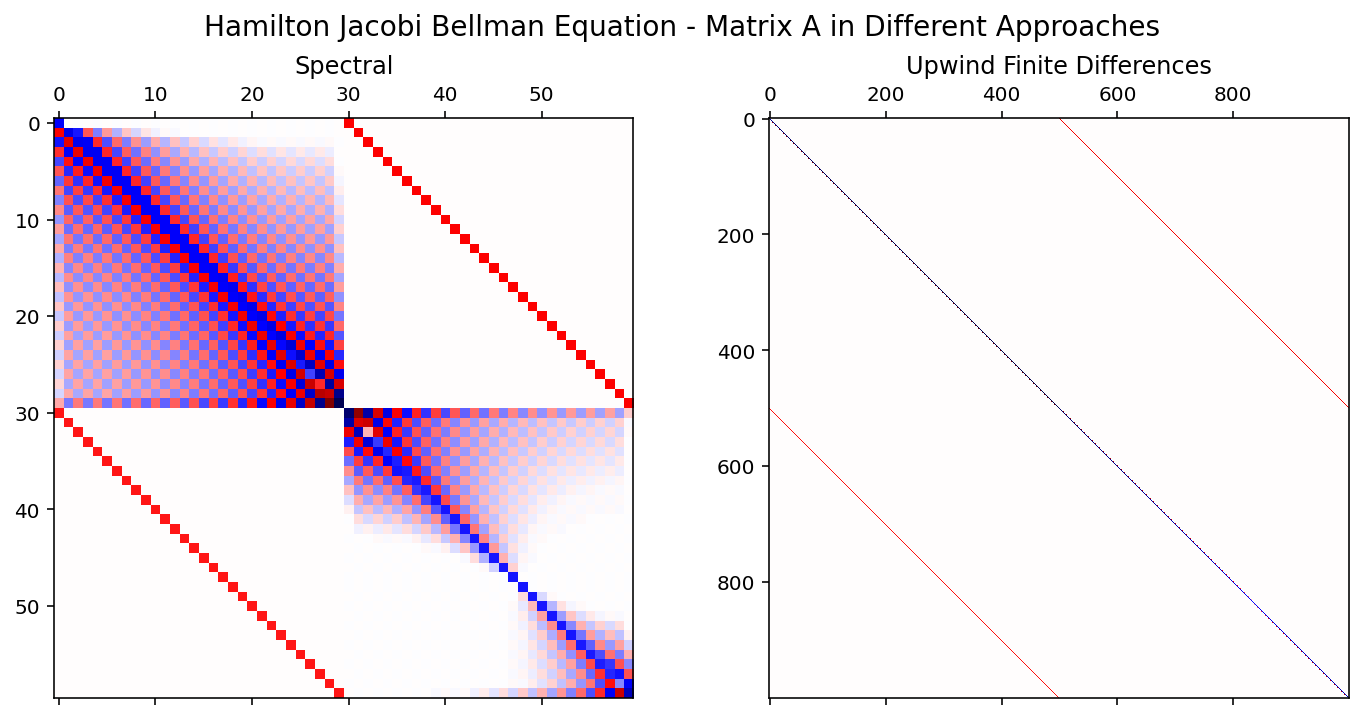

Saved to: two_state_hjb_A_matrix_plot.pdf


In [72]:
matrices = (A, A_fd.toarray())
titles = ('Spectral', 'Upwind Finite Differences')

plotmats(matrices, titles, shape=(1,2), figsize=(10,5), suptitle='Hamilton Jacobi Bellman Equation - Matrix A in Different Approaches', filename='two_state_hjb_A_matrix_plot')

# Kolmogorov Forward Equation

## Helpers

In [73]:
def normalize_distribution(g, a, method):
    if method=='finite':
        da = np.hstack([np.diff(a),0,np.diff(a),0]) #CCC
        return g/np.sum(g*da)
    elif method=='interpolation':
        mass_low = sp.interpolate.InterpolatedUnivariateSpline(a, g[:len(a)]).integral(a[0], a[-1])
        mass_high = sp.interpolate.InterpolatedUnivariateSpline(a, g[len(a):]).integral(a[0], a[-1])
        return g / (mass_low + mass_high)
    elif method=='hybrid':
        dirac_mass_low = g[0]*(a[1]-a[0])
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)]).integral(a[1], a[-1])
        dirac_mass_high = g[len(a)]*(a[1]-a[0])
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:]).integral(a[1], a[-1])
        return g / (dirac_mass_low + density_mass_low + dirac_mass_high + density_mass_high)
    else: sys.exit('Method not recognized!')

def solve_zero_eigenvector(C, a, disp=False):
    l, g = sparse.linalg.eigs(C, sigma=0, k=1)
    assert np.isreal(l) and np.isreal(g).all(), 'Zero-eigenvector is complex'
    l, g = np.real(l)[0], np.real(g).flatten()
    if disp: print('l:', l)
    return g

def compute_g(C, a, normalize_method, disp=True):
    g = solve_zero_eigenvector(C, a, disp)
    g = normalize_distribution(g, a, normalize_method)
    return g

In [74]:
def compute_g_moments(g, a, method):
    
    assert len(a) == len(g)/2
    g_assets = (g[:len(a)]+g[len(a):])
        
    if method=='finite':
        da = np.hstack([np.diff(a),0]) #CCC
        dirac_mass_low = g[0]*da[0]
        density_mass_low = np.sum(g[1:len(a)]*da[1:]) # CCC: there has to be a better way...
        dirac_mass_high = g[len(a)]*da[0]
        density_mass_high = np.sum(g[len(a)+1:]*da[1:])
        K = np.sum(g_assets*a*da)
        CDF = (g_assets*da).cumsum()
        gini = (1/K) * np.sum(da*CDF*(1-CDF))
        D1, Q1, Q3, D9 = np.interp([0.1,0.25,0.75,0.9],(da*g_assets).cumsum(),a)
    
    elif method=='interpolation':
        dirac_mass_low = np.nan
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a, g[:len(a)]).integral(a[0], a[-1])
        dirac_mass_high = np.nan
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a, g[len(a):]).integral(a[0], a[-1])
        K = sp.interpolate.InterpolatedUnivariateSpline(a, g_assets*a).integral(a[0], a[-1])
        g_assets = g_assets / sp.interpolate.CubicSpline(a, g_assets).integrate(a[0], a[-1])
        CDF_assets_ppoly = sp.interpolate.CubicSpline(a, g_assets).antiderivative()
        CDF_assets = CDF_assets_ppoly(a_sp)
        CDF_assets_quantile = lambda q: CDF_assets_ppoly.solve(q, extrapolate=False).mean()
        gini = (1/K) * sp.interpolate.CubicSpline(a, CDF_assets*(1-CDF_assets)).integrate(a[0], a[-1])
        D1, Q1, Q3, D9 = CDF_assets_quantile(0.1), CDF_assets_quantile(0.25), CDF_assets_quantile(0.75), CDF_assets_quantile(0.9) 
        
    elif method=='hybrid':
        dirac_mass_low = g[0]*(a[1]-a[0])
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)]).integral(a[1], a[-1])
        dirac_mass_high = g[len(a)]*(a[1]-a[0])
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:]).integral(a[1], a[-1])
        K = a[0]*g_assets[0]*(a[1]-a[0]) + sp.interpolate.InterpolatedUnivariateSpline(a[1:], g_assets[1:]*a[1:]).integral(a[1], a[-1])
        dirac_mass = dirac_mass_low + dirac_mass_high
        g_assets = g_assets / (dirac_mass + sp.interpolate.CubicSpline(a[1:], g_assets[1:]).integrate(a[1], amax))
        CDF_assets_trunc_ppoly = sp.interpolate.CubicSpline(a[1:], g_assets[1:]).antiderivative()
        CDF_assets_trunc = CDF_assets_trunc_ppoly(a[1:])+dirac_mass
        CDF_assets_quantile = lambda q: (q<=dirac_mass)*a[0] + (dirac_mass<q)*CDF_assets_trunc_ppoly.solve(q-dirac_mass, extrapolate=False).mean()
        gini = (1/K) * sp.interpolate.CubicSpline(a[1:], CDF_assets_trunc*(1-CDF_assets_trunc)).integrate(a[1], a[-1])
        D1, Q1, Q3, D9 = CDF_assets_quantile(0.1), CDF_assets_quantile(0.25), CDF_assets_quantile(0.75), CDF_assets_quantile(0.9)
    
    else: sys.exit('Method not recognized!')
    
    return np.array([dirac_mass_low, density_mass_low, dirac_mass_high, density_mass_high, K, gini, D1, Q1, Q3, D9])

In [75]:
def plot_g(g, a, moment_method, title='', filename='', interp=False):
        
    fig, ax = plt.subplots(figsize=(4,4))
    
    if interp:
        a_hd = np.linspace(a[1], a[-1], 1000)
        if len(a)<=100: ax.plot(a, g[:len(a)], 'C0.')
        ax.plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)])(a_hd), 'C0', label='Low-income')
        ax.plot(a[[0,1]], g[[0,1]], 'C0-')
        if len(a)<=100: ax.plot(a, g[len(a):], 'C1.')
        ax.plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:])(a_hd), 'C1', label='High-income')
        ax.plot(a[[0,1]], g[[len(a),len(a)+1]], 'C1-')
    else:
        if len(a)<=100: ax.plot(a, g[:len(a)], 'C0.')
        ax.plot(a, g[:len(a)], 'C0-', label='High-income')
        if len(a)<=100: ax.plot(a, g[len(a):], 'C1.')
        ax.plot(a, g[len(a):], 'C1-', label='High-income')
    
    ax.set_title(title)
    ax.legend(loc='upper right', frameon=False)
    
    ax.set_ylim([-0.5, 5])

    plt.tight_layout()
    savefig(ax, filename)
    
    K, gini = compute_g_moments(g, a, method=moment_method)[[4,5]]
    
    print('K:', K)
    print('Gini:', gini)

## Finite Differences

l: 1.3392186144017282e-16


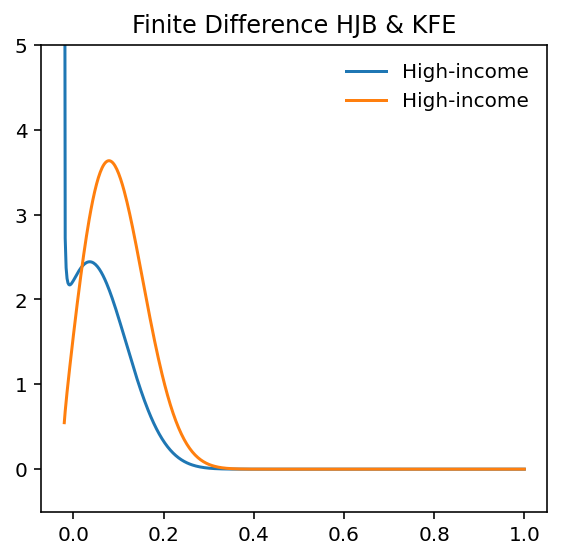

Saved to: two_state_density_fd.pdf
K: 0.0848153731677675
Gini: 0.4306858815628545


In [76]:
g_full_fd = compute_g(A_fd.T, a_fd, normalize_method='finite')
plot_g(g_full_fd, a_fd, 'finite', 'Finite Difference HJB & KFE', 'two_state_density_fd')

## Naive Spectral

l: -2.840019984748783e-13


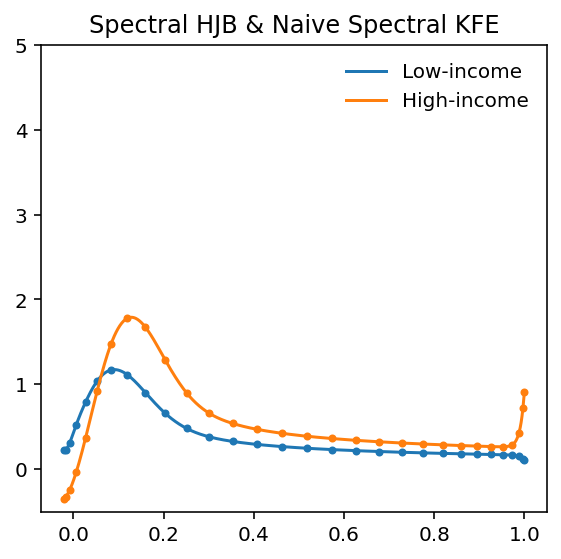

Saved to: two_state_density_naive_spectral.pdf
K: 0.3386301870525617
Gini: 0.4347347426171814


In [77]:
C_naive_spectral = -D_a*s_sp.flatten() + GG.T + 1e-5

g_naive_spectral = compute_g(C_naive_spectral, a_sp, normalize_method='interpolation')
plot_g(g_naive_spectral, a_sp, 'interpolation', 'Spectral HJB & Naive Spectral KFE', 'two_state_density_naive_spectral', interp=True)

## Spectral + Finite Differences

In [78]:
s_sp_interp = np.hstack([sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_fd), sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_fd)])

l: 1.908098892970071e-17


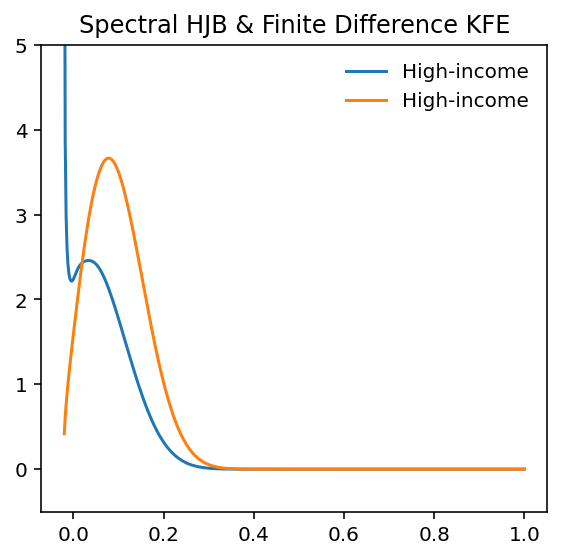

Saved to: two_state_density_spectral_fd.pdf
K: 0.0840748203034011
Gini: 0.4314098092086906


In [79]:
Dfw = (1/da_fd)*(sparse.diags(np.ones(I-1), offsets=1)-sparse.diags(np.ones(I), offsets=0))
D_fw = sparse.kron(sparse.eye(2), Dfw)

Dbw = (1/da_fd)*(sparse.diags(np.ones(I), offsets=0)-sparse.diags(np.ones(I-1), offsets=-1))
D_bw = sparse.kron(sparse.eye(2), Dbw)

C_fd = sparse.kron(G.T,sparse.eye(I)) - D_bw*sparse.diags(np.maximum(s_sp_interp, 0)) - D_fw*sparse.diags(np.minimum(s_sp_interp, 0))

g_fd = compute_g(C_fd, a_fd, normalize_method='finite')
plot_g(g_fd, a_fd, 'finite', 'Spectral HJB & Finite Difference KFE', 'two_state_density_spectral_fd')

## Spectral

l: 0.010440411982441678


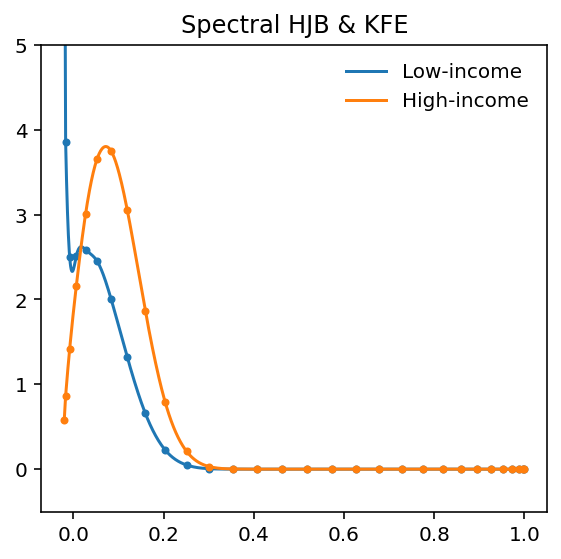

Saved to: two_state_density_spectral.pdf
K: 0.07842202535521971
Gini: 0.4442475926540119


In [80]:
da_sp = a_sp[1]-a_sp[0]

Da_cut = np.zeros_like(Da)
Da_cut[1:,1:] = Lagrange.with_unit_weights(nodes=a_sp[1:]).at_order(1)
D_a_cut = np.kron(np.eye(2), Da_cut)

C_spectral = -D_a_cut*s_sp.flatten() + GG.T

# Net flows for low-income @ bottom constraint
C_spectral[0,0], C_spectral[0,1], C_spectral[0,N] = -lambda1, -s_sp[1]/da_sp, lambda2

# Net flows for high-income @ bottom constraint
C_spectral[N,0], C_spectral[N,N] = lambda1, -lambda2-s_sp[N]/da_sp

# Net flows for high-income just above bottom constraint
C_spectral[N+1,:], C_spectral[N+1,N], C_spectral[N+1,N+1], C_spectral[N+1,1] = 0, s_sp[N]/da_sp, -lambda2-s_sp[N+1]/da_sp, lambda1

# Zero mass @ top constraint as savings are negative
C_spectral[N-1,:], C_spectral[N-1,N-1] = 0., 1.
C_spectral[-1,:], C_spectral[-1,-1] = 0., 1.

g_spectral = compute_g(C_spectral, a_sp, normalize_method='hybrid')
plot_g(g_spectral, a_sp, 'hybrid', 'Spectral HJB & KFE', 'two_state_density_spectral', interp=True)

## Plots

### Overlaid densities

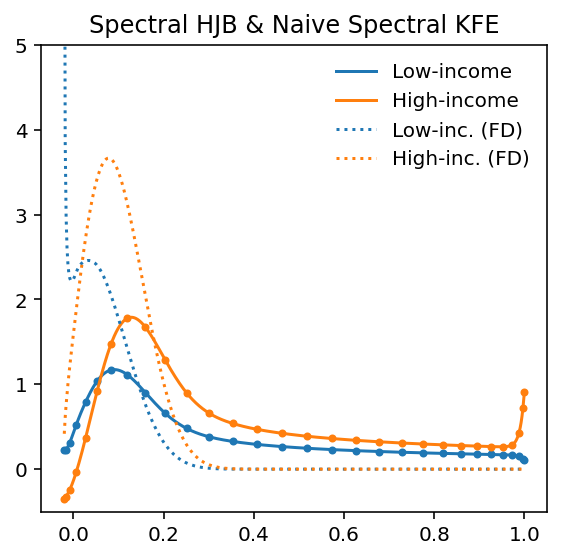

Saved to: two_state_density_naive_spectral_overlaid.pdf


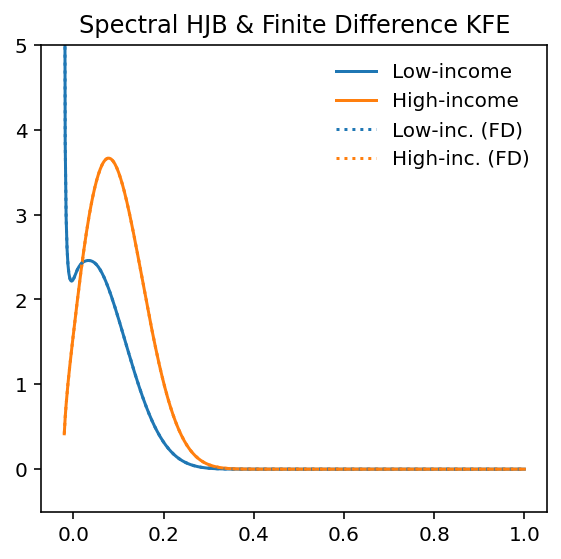

Saved to: two_state_density_spectral_fd_overlaid.pdf


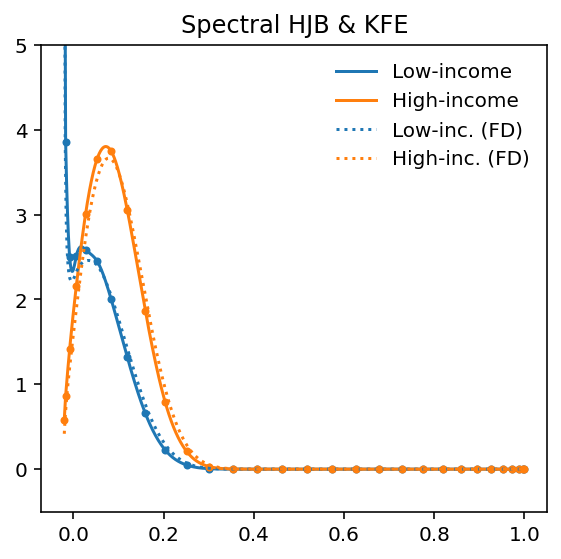

Saved to: two_state_density_spectral_overlaid.pdf


In [82]:
def plot_g_overlaid(g, a, g_full_fd, title='', filename='', interp=False):
        
    fig, ax = plt.subplots(figsize=(4,4))
    
    if interp:
        a_hd = np.linspace(a[1], a[-1], 1000)
        if len(a)<=100: ax.plot(a, g[:len(a)], 'C0.')
        ax.plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)])(a_hd), 'C0', label='Low-income')
        ax.plot(a[[0,1]], g[[0,1]], 'C0-')
        if len(a)<=100: ax.plot(a, g[len(a):], 'C1.')
        ax.plot(a_hd, sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:])(a_hd), 'C1', label='High-income')
        ax.plot(a[[0,1]], g[[len(a),len(a)+1]], 'C1-')
    else:
        if len(a)<=100: ax.plot(a, g[:len(a)], 'C0.')
        ax.plot(a, g[:len(a)], 'C0-', label='Low-income')
        if len(a)<=100: ax.plot(a, g[len(a):], 'C1.')
        ax.plot(a, g[len(a):], 'C1-', label='High-income')
        
    ax.plot(a_fd, g_fd[:I], 'C0:', label='Low-inc. (FD)')
    ax.plot(a_fd, g_fd[I:], 'C1:', label='High-inc. (FD)')
    
    ax.set_title(title)
    ax.legend(loc='upper right', frameon=False)
    
    ax.set_ylim([-0.5, 5])

    plt.tight_layout()
    savefig(ax, filename)
    
plot_g_overlaid(g_naive_spectral, a_sp, g_full_fd, 'Spectral HJB & Naive Spectral KFE', 'two_state_density_naive_spectral_overlaid', interp=True)
plot_g_overlaid(g_fd, a_fd, g_full_fd, 'Spectral HJB & Finite Difference KFE', 'two_state_density_spectral_fd_overlaid', interp=False)
plot_g_overlaid(g_spectral, a_sp, g_full_fd, 'Spectral HJB & KFE', 'two_state_density_spectral_overlaid', interp=True)

### Matrix plots

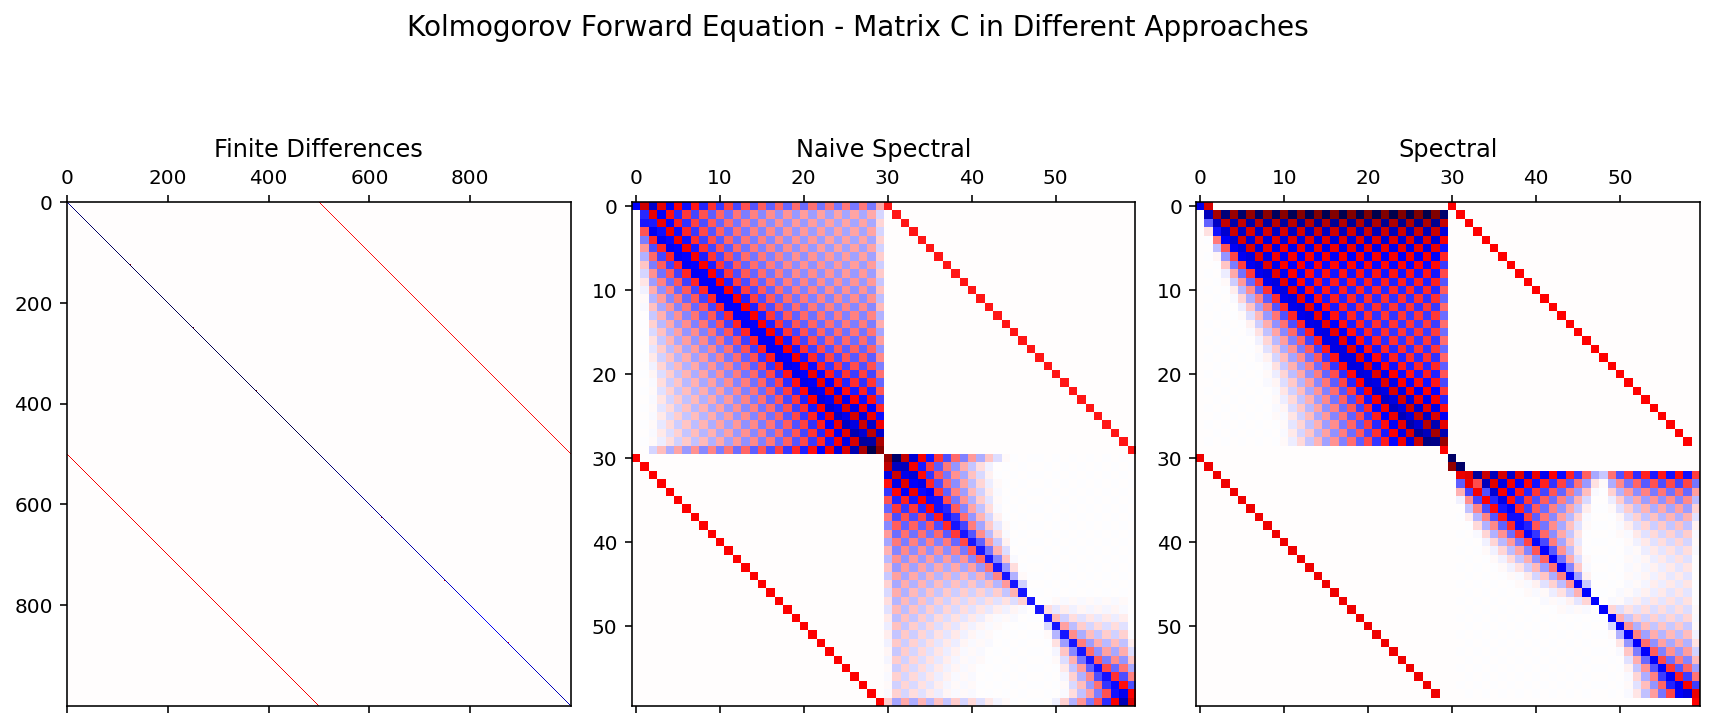

Saved to: two_state_kfe_C_matrix_plot.pdf


In [28]:
matrices = (C_fd.toarray(), C_naive_spectral, C_spectral)
titles = ['Finite Differences', 'Naive Spectral', 'Spectral']

plotmats(matrices, titles, shape=(1, 3), figsize=(12, 6), suptitle='Kolmogorov Forward Equation - Matrix C in Different Approaches', filename='two_state_kfe_C_matrix_plot')

## Side-by-side plot

# Benchmark

## Settings

In [29]:
Nmin, Nmax = 20, 500
Imin, Imax = 100, 5000

nbenchmark = (Nmax-Nmin)//2+1
nbenchmark = 100
nbenchmark = (Nmax-Nmin)+1

In [30]:
moments = ['dirac_mass_low', 'density_mass_low', 'dirac_mass_high', 'density_mass_high', 'K', 'gini', 'D1', 'Q1', 'Q3', 'D9']
computed_moments = ['total_mass_low', 'total_mass_high', 'IQR', 'IDR']

times = ['time_prolegomena', 'time_solve_hjb', 'time_solve_kfe', 'time_compute_moments']
computed_times = ['time_total']

functions = ['value', 'savings']
error_types = ['l1_error', 'l2_error', 'linf_error']
function_errors = [f+'_'+e for f in functions for e in error_types]

In [31]:
def calc_hd_error(function, a, function_hd, a_hd, interp_method, n=10000):
    assert len(a)==len(function)/2
    assert len(a_hd)==len(function_hd)/2
    
    a_uhd = np.linspace(a[0], a[-1], n)
    
    if interp_method=='polynomial':
        function_interp = np.hstack([sp.interpolate.InterpolatedUnivariateSpline(a, function[:len(a)])(a_uhd), sp.interpolate.InterpolatedUnivariateSpline(a, function[:len(a)])(a_uhd)])
        function_hd_interp = np.hstack([sp.interpolate.InterpolatedUnivariateSpline(a_hd, function_hd[:len(a_hd)])(a_uhd), sp.interpolate.InterpolatedUnivariateSpline(a_hd, function_hd[:len(a_hd)])(a_uhd)])
    elif interp_method=='linear':
        function_interp = np.hstack([np.interp(a_uhd, a, function[:len(a)]), np.interp(a_uhd, a, function[:len(a)])])
        function_hd_interp = np.hstack([np.interp(a_uhd, a_hd, function_hd[:len(a_hd)]), np.interp(a_uhd, a_hd, function_hd[:len(a_hd)])])

    l1_error = np.mean(np.abs(function_interp-function_hd_interp))
    l2_error = np.sqrt(np.mean((function_interp-function_hd_interp)**2))
    linf_error = np.max(np.abs(function_interp-function_hd_interp))
    return l1_error, l2_error, linf_error

## Spectral

In [32]:
def spectral_prolegomena(N):
    
    chebyshev = DiffMatOnDomain(xmin=amin, xmax=amax, dmat=Chebyshev(degree=N-1))
    a_sp = chebyshev.nodes
    Da = chebyshev.at_order(1)

    aa_sp = np.tile(a_sp, 2).reshape(-1,1)
    zz_sp = np.repeat(z, N).reshape(-1,1)

    D_a = np.kron(np.eye(2), Da)
    GG = np.kron(G,np.eye(N))
    
    return a_sp, aa_sp, zz_sp, D_a, GG
    
def spectral_solve_hjb(N, a_sp, aa_sp, zz_sp, D_a, GG):

    v_sp = u(zz_sp+r*aa_sp)/rho
    
    for i in range(maxiter):
        
        delta = (1/N**2)*np.exp(i)

        dv = D_a@v_sp
        c = du_inv(dv)
        s_sp = zz_sp + r*aa_sp - c

        A = s_sp.reshape(-1,1)*D_a + GG
        B = (1/delta + rho)*np.eye(2*N) - A
        b = u(c) + v_sp/delta

        B[0] = D_a[0]
        b[0] = du(zz_sp + r*aa_sp)[0]

        v_old = v_sp.copy()
        v_sp = np.linalg.solve(B,b)

        dist = np.max(np.abs(v_old-v_sp))
        if dist < crit:
            return v_sp.flatten(), s_sp.flatten()
        elif np.isnan(c).any(): sys.exit('Failure!')
        elif i==maxiter-1: sys.exit('No convergence!')
    
def spectral_solve_kfe_fd(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp):
    
    a_hd = np.linspace(a_sp[0], a_sp[-1], N*10)
    da_hd = a_hd[1]-a_hd[0]
    
    s_sp_interp = np.hstack([sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[:N])(a_hd), sp.interpolate.InterpolatedUnivariateSpline(a_sp, s_sp[N:])(a_hd)])
    
    Dfw = (1/da_hd)*(sparse.diags(np.ones(N*10-1), offsets=1)-sparse.diags(np.ones(N*10), offsets=0))
    D_fw = sparse.kron(sparse.eye(2), Dfw)

    Dbw = (1/da_hd)*(sparse.diags(np.ones(N*10), offsets=0)-sparse.diags(np.ones(N*10-1), offsets=-1))
    D_bw = sparse.kron(sparse.eye(2), Dbw)

    C_fd = sparse.kron(G.T,sparse.eye(N*10)) - D_bw*sparse.diags(np.maximum(s_sp_interp, 0)) - D_fw*sparse.diags(np.minimum(s_sp_interp, 0))

    g_fd = compute_g(C_fd, a_hd, normalize_method='finite', disp=False)

    return g_fd, a_hd

def spectral_solve_kfe_spectral(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp):
    
    da_sp = a_sp[1]-a_sp[0]

    Da_cut = np.zeros((N,N))
    Da_cut[1:,1:] = Lagrange.with_unit_weights(nodes=a_sp[1:]).at_order(1)
    
    D_a_cut = np.kron(np.eye(2), Da_cut)
    
    D_a_cut = np.kron(np.eye(2), Da_cut)
    C_spectral = -D_a_cut*s_sp.flatten() + GG.T

    C_spectral[0,0], C_spectral[0,1], C_spectral[0,N] = -lambda1, -s_sp[1]/da_sp, lambda2
    C_spectral[N,0], C_spectral[N,N] = lambda1, -lambda2-s_sp[N]/da_sp
    C_spectral[N+1,:], C_spectral[N+1,N], C_spectral[N+1,N+1], C_spectral[N+1,1] = 0, s_sp[N]/da_sp, -lambda2-s_sp[N+1]/da_sp, lambda1

    C_spectral[N-1,:], C_spectral[N-1,N-1] = 0., 1.
    C_spectral[-1,:], C_spectral[-1,-1] = 0., 1.

    g_sp = compute_g(C_spectral, a_sp, normalize_method='hybrid', disp=False)

    return g_sp

In [33]:
kfe_methods = ['None', 'fd', 'spectral']
spectral_moments_midx, _ = pd.MultiIndex.from_product([kfe_methods, moments+times+computed_moments+computed_times+function_errors], names=['kfe_method','moment']).sortlevel()

In [34]:
def normalize_distribution(g, a, method):
    if method=='finite':
        da = np.hstack([np.diff(a),0,np.diff(a),0]) #CCC
        return g/np.sum(g*da)
    elif method=='interpolation':
        mass_low = sp.interpolate.InterpolatedUnivariateSpline(a, g[:len(a)]).integral(a[0], a[-1])
        mass_high = sp.interpolate.InterpolatedUnivariateSpline(a, g[len(a):]).integral(a[0], a[-1])
        return g / (mass_low + mass_high)
    elif method=='hybrid':
        dirac_mass_low = g[0]*(a[1]-a[0])
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)]).integral(a[1], a[-1])
        dirac_mass_high = g[len(a)]*(a[1]-a[0])
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:]).integral(a[1], a[-1])
        return g / (dirac_mass_low + density_mass_low + dirac_mass_high + density_mass_high)
    else: sys.exit(f'Method {method} not recognized!')

def solve_zero_eigenvector(C, a, disp=False):
    l, g = sparse.linalg.eigs(C, sigma=0, k=1)
    assert np.isreal(l) and np.isreal(g).all(), 'Zero-eigenvector is complex'
    l, g = np.real(l)[0], np.real(g).flatten()
    if disp: print('l:', l)
    return g

def compute_g(C, a, normalize_method, disp=True):
    g = solve_zero_eigenvector(C, a, disp)
    g = normalize_distribution(g, a, normalize_method)
    return g

In [35]:
Ns = np.linspace(Nmin, Nmax, nbenchmark, dtype='int')
spectral_moments = pd.DataFrame(columns=spectral_moments_midx, index=Ns, dtype='float')
v_sp_hd, s_sp_hd, a_sp_hd = None, None, None

for N in tqdm(Ns[::-1]):
    
    try:

        time_start = timer()
        a_sp, aa_sp, zz_sp, D_a, GG = spectral_prolegomena(N)
        time_prolegomena = timer()-time_start

        time_start = timer()
        v_sp, s_sp = spectral_solve_hjb(N, a_sp, aa_sp, zz_sp, D_a, GG)
        time_solve_hjb = timer()-time_start

        if v_sp_hd is None: v_sp_hd, s_sp_hd, a_sp_hd = v_sp.copy(), s_sp.copy(), a_sp.copy()
        spectral_moments.loc[N, ('None',['value_l1_error', 'value_l2_error', 'value_linf_error'])] = calc_hd_error(v_sp, a_sp, v_sp_hd, a_sp_hd, interp_method='polynomial')
        spectral_moments.loc[N, ('None',['savings_l1_error', 'savings_l2_error', 'savings_linf_error'])] = calc_hd_error(s_sp, a_sp, s_sp_hd, a_sp_hd, interp_method='polynomial')

        time_start = timer()
        g_spectral = spectral_solve_kfe_spectral(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp)
        time_solve_kfe_spectral = timer()-time_start
        spectral_moments.loc[N, ('spectral', moments)] = compute_g_moments(g_spectral, a_sp, method='hybrid')
        time_compute_moments_spectral = timer()-time_start-time_solve_kfe_spectral
        spectral_moments.loc[N, ('spectral', times)] = time_prolegomena, time_solve_hjb, time_solve_kfe_spectral, time_compute_moments_spectral

        time_start = timer()
        g_fd, a_hd = spectral_solve_kfe_fd(N, a_sp, aa_sp, zz_sp, D_a, GG, s_sp)
        time_solve_kfe_fd = timer()-time_start
        spectral_moments.loc[N, ('fd', moments)] = compute_g_moments(g_fd, a_hd, method='finite')
        time_compute_moments_fd = timer()-time_start-time_solve_kfe_fd
        spectral_moments.loc[N, ('fd', times)] = time_prolegomena, time_solve_hjb, time_solve_kfe_fd, time_compute_moments_fd
        
    except:
        pass

  0%|          | 0/481 [00:00<?, ?it/s]

In [36]:
spectral_moments.loc[:,(slice(None),'total_mass_low')] = spectral_moments.loc[:,(slice(None),'dirac_mass_low')].values+spectral_moments.loc[:,(slice(None),'density_mass_low')].values
spectral_moments.loc[:,(slice(None),'total_mass_high')] = spectral_moments.loc[:,(slice(None),'dirac_mass_high')].values+spectral_moments.loc[:,(slice(None),'density_mass_high')].values

spectral_moments.loc[:,(slice(None),'IQR')] = spectral_moments.loc[:,(slice(None),'Q3')].values/spectral_moments.loc[:,(slice(None),'Q1')].values
spectral_moments.loc[:,(slice(None),'IDR')] = spectral_moments.loc[:,(slice(None),'D9')].values/spectral_moments.loc[:,(slice(None),'Q1')].values

for method in kfe_methods:
    spectral_moments.loc[:,(method,'time_total')] = spectral_moments.loc[:,(method,times)].sum(axis=1)

## Finite Differences

In [37]:
def fd_prolegomena(I):

    a_fd = np.linspace(amin, amax, I)
    da_fd = a_fd[1]-a_fd[0]

    aa_fd = np.tile(a_fd,(2,1))
    zz_fd = np.tile(z,(I,1)).T
    
    z_transition = sparse.kron(G,sparse.eye(I), format='csr')

    v_old = np.zeros((2,I))
    g = np.zeros((2,I))
    dv = np.zeros((2,I-1))
    cf = np.zeros((2,I-1))
    c0 = np.zeros((2,I))
    ssf = np.zeros((2,I))
    ssb = np.zeros((2,I))
    is_backward = np.zeros((2,I))
    is_forward = np.zeros((2,I))
    diag_helper = np.zeros((2,I))        
    A = z_transition.copy()
    B = z_transition.copy()
    
    return a_fd, da_fd, aa_fd, zz_fd, z_transition, v_old, g, dv, cf, c0, ssf, ssb, is_backward, is_forward, diag_helper, A, B
    
def fd_solve_hjb(I, a_fd, da_fd, aa_fd, zz_fd, z_transition, v_old, g, dv, cf, c0, ssf, ssb, is_backward, is_forward, diag_helper, A, B):
    
    v_fd = u(r*aa_fd + zz_fd)/rho

    for i in range(maxiter):
        
        delta = 10*(1/N**2)*np.exp(i)

        dv = (v_fd[:,1:]-v_fd[:,:-1])/da_fd
        cf = du_inv(dv)
        c0 = r*aa_fd + zz_fd

        ssf[:,:-1] = c0[:,:-1]-cf
        ssb[:,1:] = c0[:,1:]-cf

        is_backward = ssf>0
        is_forward = ssb<0

        c0[:,:-1] += (cf-c0[:,:-1])*is_backward[:,:-1]
        c0[:,1:] += (cf-c0[:,1:])*is_forward[:,1:]

        A = z_transition.copy()
        diag_helper = (-ssf*is_backward/da_fd + ssb*is_forward/da_fd).flatten()
        A += sparse.spdiags(diag_helper,0,2*I,2*I)
        diag_helper = (-ssb*is_forward/da_fd).flatten()
        A += sparse.spdiags(diag_helper[1:],-1,2*I,2*I)
        diag_helper = (ssf*is_backward/da_fd).flatten()
        A += sparse.spdiags(np.hstack((0,diag_helper)),1,2*I,2*I)

        B = sparse.eye(2*I)*(1/delta + rho) - A
        b = u(c0).reshape(-1,1) + v_fd.reshape(-1,1)/delta
        A_fd, v_old, s_fd = A.copy(), v_fd.copy(), (r*aa_fd + zz_fd - c0)
        v_fd = spsolve(B,b).reshape(2,I)

        dist = np.max(np.abs(v_old-v_fd))
        
        if dist < crit: return v_fd.flatten(), A_fd, s_fd.flatten()
        elif i==maxiter-1: sys.exit('No convergence!')
    
def fd_solve_kfe(I, A_fd):
    
        AT_fd = A_fd.T.tocsr()
        b = np.zeros((2*I,1))
        b[0] = 0.1
        AT_fd.data[1:AT_fd.indptr[1]] = 0
        AT_fd.data[0] = 1.0
        AT_fd.indices[0] = 0
        AT_fd.eliminate_zeros()
        
        g_fd = spsolve(AT_fd,b)
        g_fd = g_fd/(da_fd*g_fd.sum())
        
        return g_fd

In [38]:
Is = np.geomspace(Imin, Imax, nbenchmark).astype('int')
fd_moments = pd.DataFrame(columns=moments, index=Is, dtype='float')

for I in tqdm(Is[::-1]):
                
    try:
        time_start = timer()
        a_fd, da_fd, aa_fd, zz_fd, z_transition, v_old, g, dv, cf, c0, ssf, ssb, is_backward, is_forward, diag_helper, A, B = fd_prolegomena(I)
        time_prolegomena = timer()-time_start

        v_fd, A_fd, s_fd = fd_solve_hjb(I, a_fd, da_fd, aa_fd, zz_fd, z_transition, v_old, g, dv, cf, c0, ssf, ssb, is_backward, is_forward, diag_helper, A, B)
        time_solve_hjb = timer()-time_start-time_prolegomena

        g_fd = fd_solve_kfe(I, A_fd)
        time_solve_kfe = timer()-time_start-time_prolegomena-time_solve_hjb

        fd_moments.loc[I, moments] = compute_g_moments(g_fd, a_fd, method='finite')
        time_compute_moments = timer()-time_start-time_prolegomena-time_solve_hjb-time_solve_kfe

        fd_moments.loc[I, times] = time_prolegomena, time_solve_hjb, time_solve_kfe, time_compute_moments

        if I == Is[-1]: v_fd_hd, s_fd_hd, g_fd_hd, a_fd_hd = v_fd.copy(), s_fd.copy(), g_fd.copy(), a_fd.copy()
        fd_moments.loc[I, ['value_l1_error', 'value_l2_error', 'value_linf_error']] = calc_hd_error(v_fd, a_fd, v_fd_hd, a_fd_hd, interp_method='linear')
        fd_moments.loc[I, ['savings_l1_error', 'savings_l2_error', 'savings_linf_error']] = calc_hd_error(s_fd, a_fd, s_fd_hd, a_fd_hd, interp_method='linear')
    except: pass

  0%|          | 0/481 [00:00<?, ?it/s]

In [39]:
fd_moments['total_mass_low'] = fd_moments['dirac_mass_low']+fd_moments['density_mass_low']
fd_moments['total_mass_high'] = fd_moments['dirac_mass_high']+fd_moments['density_mass_high']

fd_moments['IQR'] = fd_moments['Q3']/fd_moments['Q1']
fd_moments['IDR'] = fd_moments['D9']/fd_moments['Q1']

fd_moments['time_total'] = fd_moments[times].sum(axis=1)

## Results

### Execution Time vs Number of Nodes

In [40]:
times_colors = dict(zip(times,['#f08080','#f4978e','#f8ad9d','#fbc4ab']))
times_colors = dict(zip(times,['C0','C1','C2','C3']))
pretty_times = dict(zip(times,['Init.','HJB','KFE','Moments']))

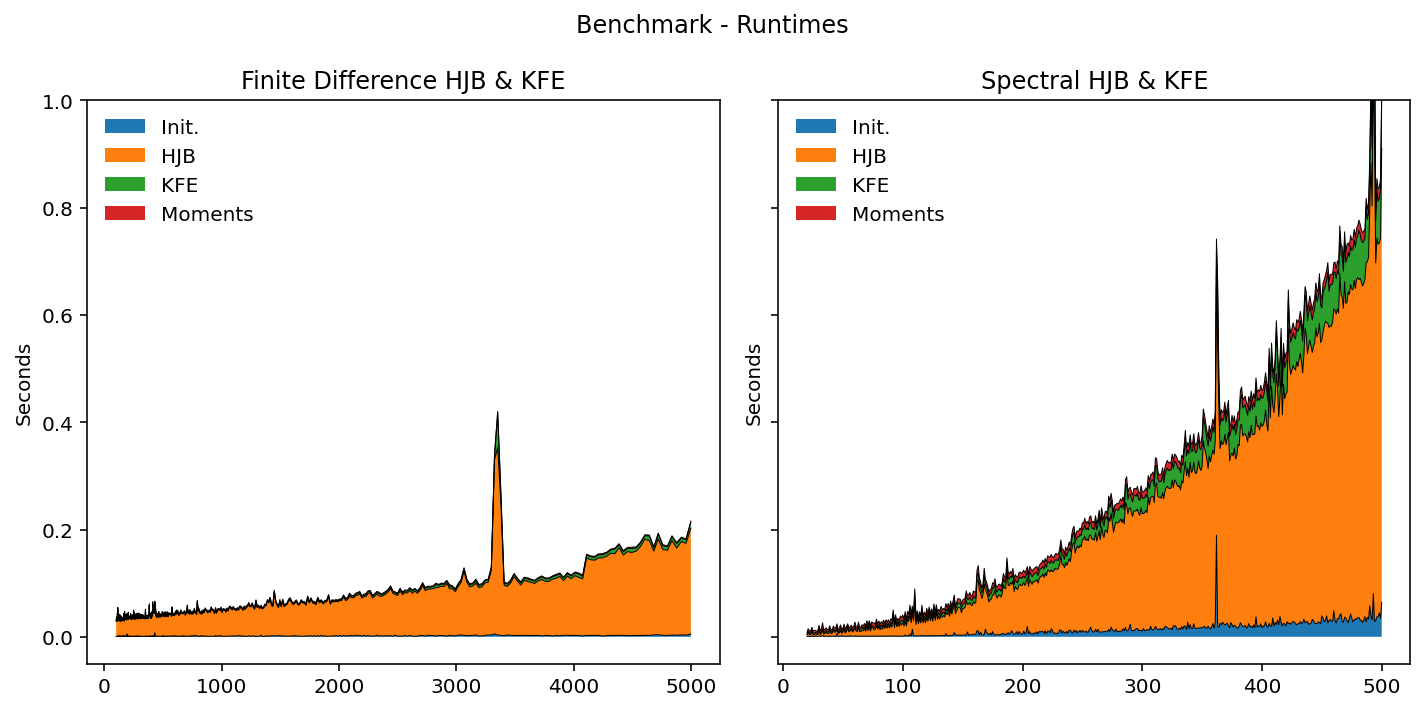

Saved to: two_state_benchmark_runtimes.pdf


In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, tight_layout=True)
ax = ax.flatten()

dfs_times = [fd_moments[times], spectral_moments['spectral'][times]]
Xss = [Is, Ns]
titles = ['Finite Difference HJB & KFE', 'Spectral HJB & KFE']

for j, [df_times, Xs, title] in enumerate(zip(dfs_times, Xss, titles)):
    df_times = df_times.dropna()
    cumsum = 0*df_times[times[0]].values
    for i, time in enumerate(times):
        ax[j].fill_between(df_times.index, cumsum, cumsum+df_times[time], facecolor=times_colors[time], label=pretty_times[time])
        ax[j].plot(df_times.index, cumsum+df_times[time], 'k', lw=0.5)
        cumsum += df_times[time]
    ax[j].legend(frameon=False, loc='upper left')
    ax[j].set_title(title)
    ax[j].set_ylabel('Seconds')

plt.ylim([-0.05, 1.])
plt.suptitle('Benchmark - Runtimes')
plt.tight_layout()
savefig(fig, 'two_state_benchmark_runtimes')

### Errors vs Number of Nodes

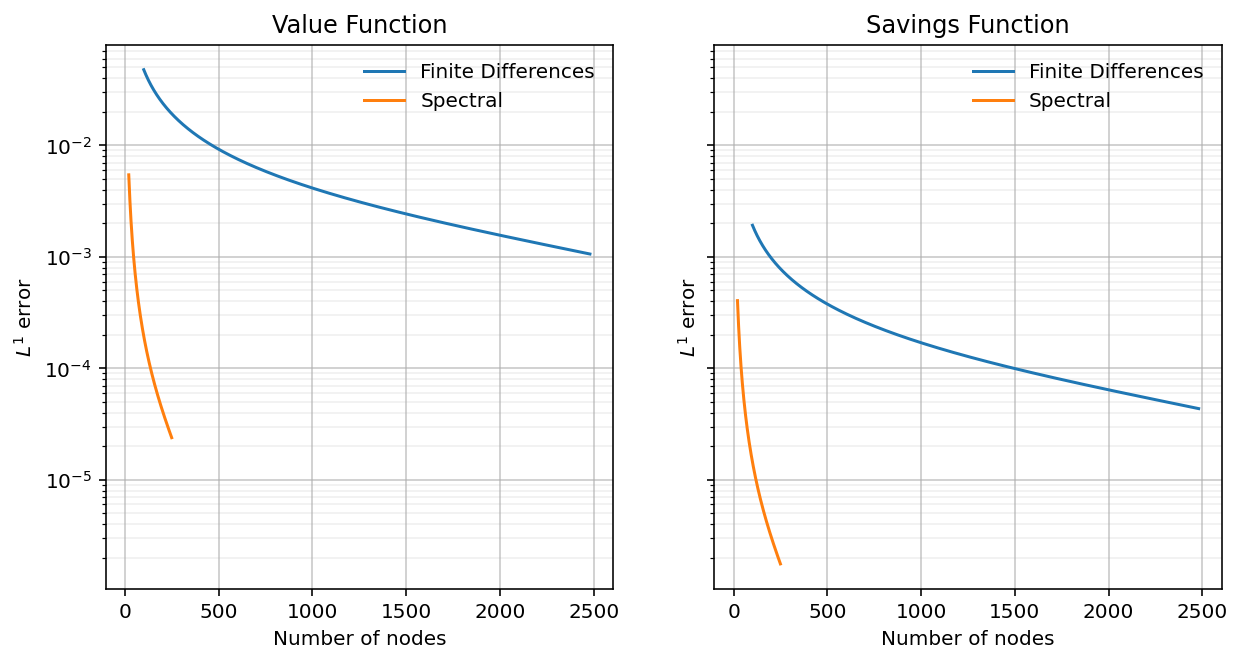

Saved to: two_state_benchmark_errors_functions.pdf


In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

Ihalf = np.where(Is>=max(Is)/2)[0][0]
Nhalf = np.where(Ns>=max(Ns)/2)[0][0]

for i, function in enumerate(['value','savings']):

    ax[i].plot(Is[:Ihalf], fd_moments[function+'_l1_error'][:Ihalf], label='Finite Differences')
    ax[i].plot(Ns[:Nhalf], spectral_moments['None', function+'_l1_error'][:Nhalf], label='Spectral')

    ax[i].set_yscale('log')
    ax[i].grid(which='minor', alpha=0.2)
    ax[i].grid(which='major', alpha=0.7)

    ax[i].set_xlabel('Number of nodes')
    ax[i].set_ylabel('$L^1$ error')
    ax[i].set_title(function.capitalize() + ' Function')
    ax[i].legend(frameon=False)

savefig(ax, 'two_state_benchmark_errors_functions')

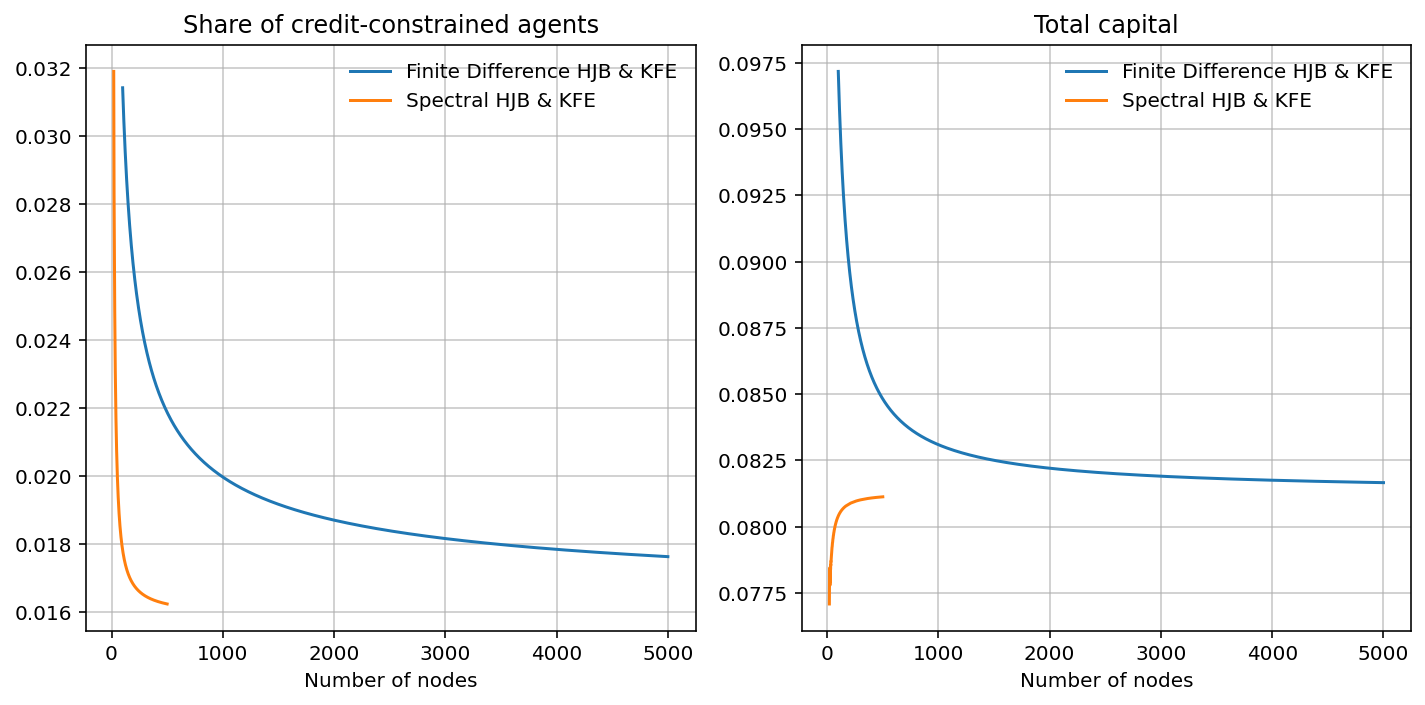

Saved to: two_state_benchmark_errors_moments.pdf


In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True, tight_layout=True)

ax[0].plot(Is, fd_moments['dirac_mass_low'], label='Finite Difference HJB & KFE')
ax[0].plot(spectral_moments['spectral', 'dirac_mass_low'].index, spectral_moments['spectral', 'dirac_mass_low'], 'C1', label='Spectral HJB & KFE')
ax[0].set_title('Share of credit-constrained agents')

ax[1].plot(Is, fd_moments['K'], label='Finite Difference HJB & KFE')
ax[1].plot(spectral_moments['spectral', 'K'].index, spectral_moments['spectral', 'K'], 'C1', label='Spectral HJB & KFE')
ax[1].set_title('Total capital')

for axis in ax:
    axis.grid(which='minor', alpha=0.2)
    axis.grid(which='major', alpha=0.7)
    axis.set_xlabel('Number of nodes')
    axis.legend(frameon=False)
    
savefig(ax, 'two_state_benchmark_errors_moments')

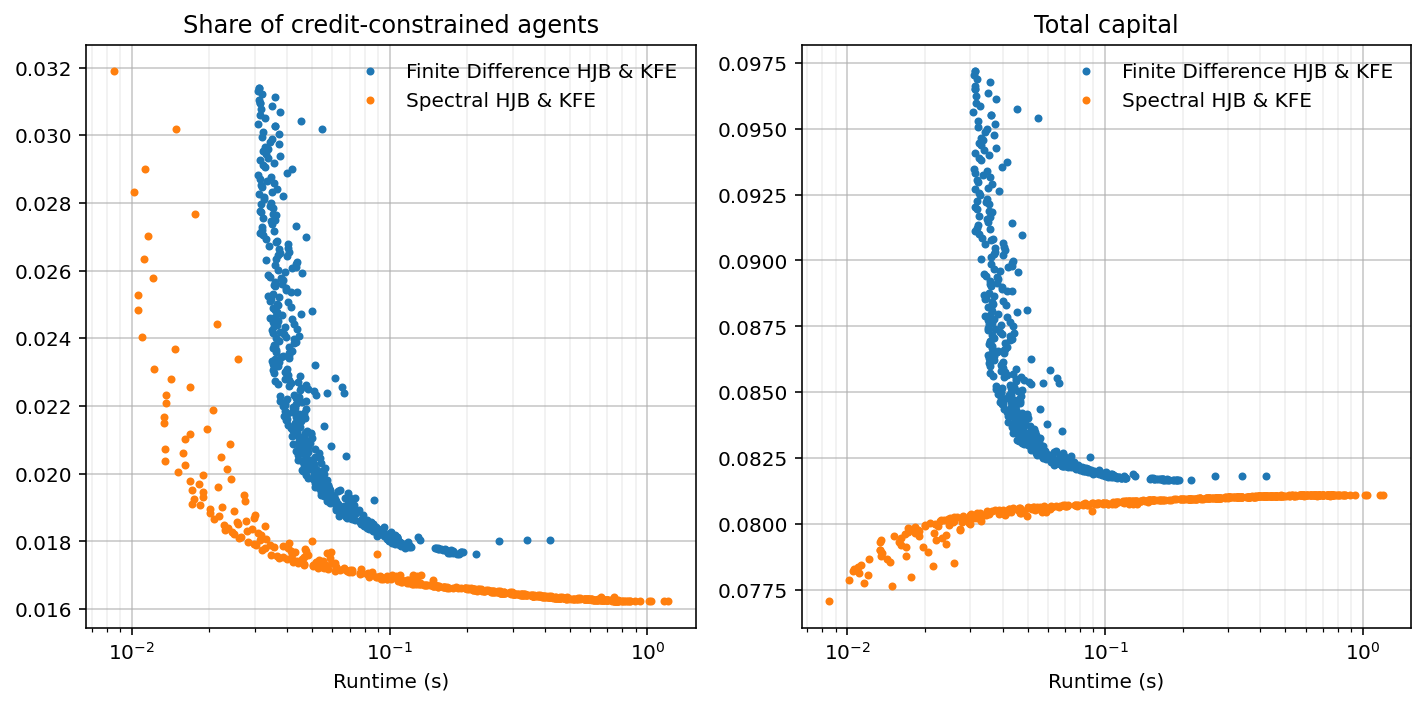

Saved to: two_state_benchmark_errors_moments_vs_time.pdf


In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True, tight_layout=True)

ax[0].plot(fd_moments['time_total'], fd_moments['dirac_mass_low'], '.', label='Finite Difference HJB & KFE')
ax[0].plot(spectral_moments['spectral', 'time_total'], spectral_moments['spectral', 'dirac_mass_low'], '.', label='Spectral HJB & KFE')
ax[0].set_title('Share of credit-constrained agents')

ax[1].plot(fd_moments['time_total'], fd_moments['K'], '.', label='Finite Difference HJB & KFE')
ax[1].plot(spectral_moments['spectral', 'time_total'], spectral_moments['spectral', 'K'], '.', label='Spectral HJB & KFE')
ax[1].set_title('Total capital')

for axis in ax:
    axis.grid(which='minor', alpha=0.2)
    axis.grid(which='major', alpha=0.7)
    axis.set_xscale('log')
    axis.set_xlabel('Runtime (s)')
    axis.legend(frameon=False)

savefig(ax, 'two_state_benchmark_errors_moments_vs_time')